In [15]:
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [16]:
import pm4py

In [17]:
def extractObjects(ocel):
    df = pd.DataFrame(ocel.objects)
    grouped = df.groupby('ocel:type')

    # Create a dictionary to store DataFrames for each group
    type_dataframes = {}

    # Iterate through each group and store it in the dictionary
    for group_name, group_data in grouped:
        type_dataframes[group_name] = group_data.copy()

    # Drop empty columns
    for type_name, type_dataframe in type_dataframes.items():
        type_dataframes[type_name].dropna(axis=1, how='all', inplace=True)

    return type_dataframes

def extractObjectsDF(df):
    grouped = df.groupby('ocel:type')

    # Create a dictionary to store DataFrames for each group
    type_dataframes = {}

    # Iterate through each group and store it in the dictionary
    for group_name, group_data in grouped:
        type_dataframes[group_name] = group_data.copy()

    # Drop empty columns
    for type_name, type_dataframe in type_dataframes.items():
        type_dataframes[type_name].dropna(axis=1, how='all', inplace=True)

    return type_dataframes

#returns a list of all object types when given the data frame

def extractObjectTypes(objects):
    objectTypes = list(objects.keys())
    return objectTypes


In [18]:
def adjustLogOLD(log):
    o2os=log.o2o
    objects=log.objects
    # Filter objects dataframe to get items and products
    items = objects[objects["ocel:type"] == "items"]
    products = objects[objects["ocel:type"] == "products"]

    # Filter o2os to get only the relationships where qualifier is "is a"
    is_a_relationships = o2os[o2os["ocel:qualifier"] == "is a"]

    # Merge is_a_relationships with items to get items associated with products
    items_with_relationships = items.merge(is_a_relationships, left_on="ocel:oid", right_on="ocel:oid")

    # Merge with products to get the product attributes
    items_with_product = items_with_relationships.merge(products, left_on="ocel:oid_2", right_on="ocel:oid", suffixes=("_item", "_product"))

    # Add the new 'product' column with the product id
    items_with_product['product'] = items_with_product['ocel:oid_product']

    # Select the relevant columns (including the new 'product' column)
    items_with_product = items_with_product[["ocel:oid_item", "role_item", "weight_item", "price_item", "ocel:type_item", "product"]]
    items_with_product.columns = ["ocel:oid", "role", "weight", "price", "ocel:type", "product"]

    # Remove products from the original objects dataframe
    objects_no_products = objects[objects["ocel:type"] != "products"]

    # Update the objects dataframe with the new items_with_product dataframe
    objects_updated = objects_no_products.merge(items_with_product, on=["ocel:oid", "role", "weight", "price", "ocel:type"], how="left")
    
    product_oids = objects[objects["ocel:type"] == "products"]["ocel:oid"].tolist()

    # Filter the 'o2os' dataframe to exclude rows where 'ocel:oid' or 'ocel:oid_2' is in 'product_oids'
    o2os_filtered = o2os[~(o2os["ocel:oid"].isin(product_oids) | o2os["ocel:oid_2"].isin(product_oids))]

    # Ensure product column is placed to the right
    columns = objects_no_products.columns.tolist() + ['product']
    objects_updated = objects_updated[columns]
    # Custom function to determine if an item is premium
    df = objects_updated
    def is_premium(row):
        if pd.notna(row['price']):
            return row['price'] > 500.0
        return None

    # Add a new column 'is_premium' using the custom function
    df['is_premium'] = df.apply(is_premium, axis=1)
    
    
    
    
    # Define a function to estimate volume based on weight
    def calculate_volume(row):
        if row['ocel:type'] == 'packages':
            weight = row['weight']
            # Define thresholds for volume based on weight
            if weight < 1:
                # Small package: volume is weight * 4000 (more compact)
                return weight * 4000
            elif 1 <= weight <= 5:
                # Medium package: volume is weight * 5000
                return weight * 5000
            else:
                # Large package: volume is weight * 6000 (bulkier packaging)
                return weight * 6000
        else:
            # Return NaN for non-package types
            return np.nan

    # Apply the function to each row to create the 'volume' column
    df['volume'] = df.apply(calculate_volume, axis=1)
        
    objects_updated = df
        
    return objects_updated,o2os_filtered

In [19]:
def adjustLog(log):
    objects=log.objects
    o2os = log.o2o
    df = objects
    def is_premium(row):
        if pd.notna(row['price']):
            return row['price'] > 500.0
        return None

    # Add a new column 'is_premium' using the custom function
    df['is_premium'] = df.apply(is_premium, axis=1)
    
    objects = df
    
    # Step 1: Filter `objects` to get only customers and their `kdtyp`
    # Rename `ocel:oid` as `customer_oid` for clarity
    customers = objects[objects['ocel:type'] == 'customers'][['ocel:oid', 'kdtyp']].copy()
    customers = customers.rename(columns={'ocel:oid': 'customer_oid'})

    # Step 2: Filter `o2os` for "places" relationships
    # Here, `ocel:oid` is the customer, and `ocel:oid_2` is the order
    order_customer_relationships = o2os[o2os['ocel:qualifier'] == 'places'][['ocel:oid', 'ocel:oid_2']].copy()
    order_customer_relationships = order_customer_relationships.rename(columns={'ocel:oid': 'customer_oid', 'ocel:oid_2': 'order_oid'})


    # Step 3: Merge `order_customer_relationships` with `customers` to bring `kdtyp` into each order
    order_with_kdtyp = order_customer_relationships.merge(customers, on='customer_oid', how='left')


    # Step 4: Merge `order_with_kdtyp` back with the original `objects` DataFrame to add `kdtyp` to orders
    # This will add `kdtyp` to each order in the original `objects` DataFrame based on the linked customer
    final_objects = objects.merge(order_with_kdtyp[['order_oid', 'kdtyp']], left_on='ocel:oid', right_on='order_oid', how='left')

    # Drop the extra `order_oid` column since `ocel:oid` already represents the order ID
    final_objects = final_objects.drop(columns=['order_oid'])

    # Merge the two `kdtyp` columns: prioritize the `kdtyp` from the orders, and use the original `kdtyp` where it exists for customers
    final_objects['kdtyp'] = final_objects['kdtyp_x'].fillna(final_objects['kdtyp_y'])

    # Drop the now-redundant `kdtyp_x` and `kdtyp_y` columns
    final_objects = final_objects.drop(columns=['kdtyp_x', 'kdtyp_y'])
    
    final_objects = final_objects[final_objects["ocel:type"].isin(["items","orders","packages","employees","customers"])]
    
    
    return final_objects,o2os

In [20]:
def plot(pd, title):
    # Print the resulting probability distribution
    probability_distribution = pd
    keys = list(probability_distribution.keys())
    values = list(probability_distribution.values())

    # Create a bar chart
    plt.bar(keys, values)

    # Set labels and title
    plt.xlabel('Items')
    plt.ylabel('Probability')
    plt.title(title)

    # Show the plot
    plt.show()

def getAttributes(log):
    df = pd.DataFrame(log.objects)
    typeAttributes = {}
    # Iterate over unique types
    for type_value in df['ocel:type'].unique():
        # Filter DataFrame rows for the current type
        type_df = df[df['ocel:type'] == type_value]
        
        # Get non-empty column names for the current type
        non_empty_columns = type_df.dropna(axis=1, how='all').columns.tolist()
        
        # Store non-empty column names in the dictionary
        typeAttributes[type_value] = non_empty_columns
    for type_value, column_names in typeAttributes.items():
        typeAttributes[type_value] = [col for col in column_names if col not in ['ocel:oid', 'ocel:type']]
    return(typeAttributes)

def calcORMDs(o2os,type1,type2,qualifier):

    o2os = o2os[o2os["ocel:qualifier"]== qualifier]
    o2os.drop(columns=["ocel:qualifier"], inplace=True)
    obs = extractObjectsDF(adjusted_log)
    id_type_dict = {}
    for key in obs:
        df = obs[key]
        new_dict = dict(zip(df['ocel:oid'], df['ocel:type']))
        id_type_dict.update(new_dict)



    o2os['ocel:type'] = o2os['ocel:oid'].map(id_type_dict)
    o2os['ocel:type_2'] = o2os['ocel:oid_2'].map(id_type_dict)
    new_order = ['ocel:oid','ocel:type','ocel:oid_2','ocel:type_2']
    o2os = o2os[new_order]

    df = o2os
    # Filter rows based on 'ocel:type' and 'ocel:type_2'
    filtered_df = df[df['ocel:type'].isin([type1]) & df['ocel:type_2'].isin([type2])]

    
    df = filtered_df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution1 = {key: count / total_elements for key, count in counts.items()}

    #reverse ORMD:


    def swap(row,index):
        t2 = row['ocel:type_2']
        id2 = row['ocel:oid_2']
        df.at[index, 'ocel:type_2'] = row["ocel:type"]
        df.at[index, 'ocel:oid_2'] = row["ocel:oid"]
        df.at[index, 'ocel:type'] = t2
        df.at[index, 'ocel:oid'] = id2


    for index, row in df.iterrows():
        if row["ocel:type_2"] == type2:
            swap(row,index)

    filtered_df = df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution2 = {key: count / total_elements for key, count in counts.items()}


    return(probability_distribution1, probability_distribution2)


def support(action,ORMDS,AORMDS):
    if action["action"]== "emit":
        if action["direction"]== 0:
            ob1 = action["object"]
            X = 0
            Y = 0
            ob1rels = ob1.relations
            for (ob,q) in ob1rels:
                if ob.type == action["type"] and action["qualifier"]== q:
                    X = X+1
            if ((ob1.type,action["type"],action["qualifier"]) in ORMDS):

                ob1perob2 = ORMDS[ob1.type,action["type"],action["qualifier"]][0]
                ob2perob1 = ORMDS[ob1.type,action["type"],action["qualifier"]][1]
            else:
                for key, value in AORMDS.items():
                    if key[0] == ob1.type and key[1] == action["type"]:
                        mia = key[2]
                        break

                ob1perob2 = AORMDS[ob1.type,action["type"],mia,ob1.attributes[mia],action["qualifier"]][0]
                ob2perob1 = AORMDS[ob1.type,action["type"],mia,ob1.attributes[mia],action["qualifier"]][1]
            

            if ob1perob2 == {}:
                return 0
            if ob2perob1 == {}:
                return 0
            probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>=X+1)
            probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
            conditionalProb1 = probXintersect / probXgeq
            probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>=Y+1)
            probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
            conditionalProb2 = probYintersect / probYgeq


            return min(conditionalProb1,conditionalProb2)
        if action["direction"]== 1:
            ob2 = action["object"]
            X = 0
            Y = 0
            for (obj,q) in ob2.reverse_relations:
                if obj.type==action["type"] and action["qualifier"]== q:
                    Y=Y+1
            if ((action["type"],ob2.type,action["qualifier"]) in ORMDS):

                ob1perob2 = ORMDS[action["type"],ob2.type,action["qualifier"]][0]
                ob2perob1 = ORMDS[action["type"],ob2.type,action["qualifier"]][1]
            else:
                for key, value in AORMDS.items():
                    if key[0] == action["type"] and key[1] == ob2.type:
                        mia = key[2]
                        break

                ob1perob2 = AORMDS[action["type"],ob2.type,mia,"PR",action["qualifier"]][0]
                ob2perob1 = AORMDS[action["type"],ob2.type,mia,"PR",action["qualifier"]][1]
            
            if ob1perob2 == {}:
                return 0
            if ob2perob1 == {}:
                return 0
            probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>=X+1)
            probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
            conditionalProb1 = probXintersect / probXgeq
            probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>=Y+1)
            probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
            conditionalProb2 = probYintersect / probYgeq


            return min(conditionalProb1,conditionalProb2)

    if action["action"]== "append":
        ob2 = action["object2"]
        ob1 = action["object1"]
    
        if ob2 == ob1:
            return 0
        X = 0
        Y = 0


        ob1rels = ob1.relations
        for (ob,q) in ob1rels:
            if ob.type == ob2.type and action["qualifier"]== q:
                X = X+1
        ob2rels = ob2.relations
        # Zähle wie oft insgesamt auf ob2 gezeigt wird von objekten von typ ob1.type
        for (obj,q) in ob2.reverse_relations:
            if obj.type==ob1.type:
                Y=Y+1
        #for ob in ob2rels:
        #    if ob.type == ob1.type:
        #        Y = Y+1
        
        if ((ob1.type,ob2.type,action["qualifier"]) in ORMDS):
            ob1perob2 = ORMDS[ob1.type,ob2.type,action["qualifier"]][0]
            ob2perob1 = ORMDS[ob1.type,ob2.type,action["qualifier"]][1]
        else:
            for key, value in AORMDS.items():
                    if key[0] == ob1.type and key[1] == ob2.type:
                        mia = key[2]

                        ob1perob2 = AORMDS[ob1.type,ob2.type,mia,ob1.attributes[mia],action["qualifier"]][0]
                        ob2perob1 = AORMDS[ob1.type,ob2.type,mia,ob1.attributes[mia],action["qualifier"]][1]
                        break



        if ob1perob2 == {}:
            return 0
        if ob2perob1 == {}:
            return 0

        probXintersect = sum(ob1perob2[x] for x in ob1perob2 if x>= X and x>=X+1)
        probXgeq = sum(ob1perob2[x] for x in ob1perob2 if x>= X)
        conditionalProb1 = probXintersect / probXgeq
        probYintersect = sum(ob2perob1[x] for x in ob2perob1 if x>= Y and x>=Y+1)
        probYgeq = sum(ob2perob1[x] for x in ob2perob1 if x>= Y)
        if probYgeq == 0:
            return 0
        conditionalProb2 = probYintersect / probYgeq
        

        return min(conditionalProb1,conditionalProb2)
        
    return 0.5



In [21]:
def calcAORMDs(o2os,objectdf,type1,type2,specialAtt,value,qualifier):

    o2os = o2os[o2os["ocel:qualifier"]== qualifier]
    o2os.drop(columns=["ocel:qualifier"], inplace=True)

    obs = extractObjectsDF(adjusted_log)
    #under the assumption that object of type1 has this particular specialAtt value

    
    id_type_dict = {}
    for key in obs:
        df = obs[key]
        new_dict = dict(zip(df['ocel:oid'], df['ocel:type']))
        id_type_dict.update(new_dict)

    o2os['ocel:type'] = o2os['ocel:oid'].map(id_type_dict)
    o2os['ocel:type_2'] = o2os['ocel:oid_2'].map(id_type_dict)
    new_order = ['ocel:oid','ocel:type','ocel:oid_2','ocel:type_2']
    o2os = o2os[new_order]

    # Merge o2os with objects to include the specialAtt column based on ocel:oid_1
    merged_df = o2os.merge(objectdf[['ocel:oid', specialAtt]], on='ocel:oid', how='left')


    
    df = merged_df
    # Filter rows based on 'ocel:type' and 'ocel:type_2'
    filtered_df = df[df['ocel:type'].isin([type1]) & df['ocel:type_2'].isin([type2])&df[specialAtt].isin([value])]

    
    df = filtered_df


    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution1 = {key: count / total_elements for key, count in counts.items()}

    #reverse ORMD:


    def swap(row,index):
        t2 = row['ocel:type_2']
        id2 = row['ocel:oid_2']
        df.at[index, 'ocel:type_2'] = row["ocel:type"]
        df.at[index, 'ocel:oid_2'] = row["ocel:oid"]
        df.at[index, 'ocel:type'] = t2
        df.at[index, 'ocel:oid'] = id2


    for index, row in df.iterrows():
        if row["ocel:type_2"] == type2:
            swap(row,index)

    filtered_df = df

    # Step 2: Group by 'ocel:oid' and count the number of unique 'ocel:oid_2' values
    order_relations_count = filtered_df.groupby('ocel:oid')['ocel:oid_2'].nunique()

    # Create a dictionary with 'ocel:oid' of each order as keys and the count as values
    order_item_relations = dict(zip(order_relations_count.index, order_relations_count))
    values_list = list(order_item_relations.values())
    # Count the occurrences of each integer
    integer_list = values_list
    counts = Counter(integer_list)

    # Calculate the total number of elements in the list
    total_elements = len(integer_list)

    # Create a probability distribution by dividing the count of each integer by the total number of elements
    probability_distribution2 = {key: count / total_elements for key, count in counts.items()}


    return(probability_distribution1, probability_distribution2)

In [22]:
#method takes dataframe of possible attribute values, 
#type attributes is a map of maps: typeAttributes[type]-> attributes{} ; attributes[att]-> "independent" / "dependent"

def generateIndependendAtts(typeAttributes,objectdf,type,classifier):
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "independent":
            if classifier[a]== "ca":
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)
            if classifier[a]== "di":
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)
            if classifier[a]=="co": 
                    df = objectdf
                    l = df.loc[df['ocel:type'] == type, a].tolist()
                    #sampling values
                    unique_values, counts = np.unique(l, return_counts=True)
                    probabilities = counts / len(l)
                    attr[a] = np.random.choice(unique_values,p=probabilities)

    return attr

In [23]:
def generateDependendAtts(typeAttributes,dependencies,type,independentAtts,distributions,objectdf,classifier):
    #get list of dependencies then assign values to dependent attributes accordingly
    #dependencies: independentAtt -> dependentAtt[]
    #to simplify: every attribute is dependent on a maximum of one independent attribute but multiple attributes can be dependent on this independent attribute
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "dependent":
            #a is the dependent attribute i want to generate
            #now i need to find out on which independent attribute it depends
            for indAtt in dependencies:
                if a in dependencies[indAtt]:
                    #indAtt is the independent attribute that 'a' is dependent on
                    val = independentAtts[indAtt]
                    #check if a distribution of values for my attribute 'a' from datapoints in which my object had the attribute value of indAtt exists
                    #if not create one
                    if (a,indAtt,val) in distributions:
                        dist = distributions[(a,indAtt,val)]
                        unique_values = list(dist.keys())
                        unique_values = np.array(unique_values)
                        probabilities = list(dist.values())
                        if classifier[a]=="ca":
                             attr[a]= random.choices(unique_values,probabilities)[0]
                        if classifier[a]=="co": 
                            interpolated_pdf = interp1d(unique_values, probabilities, kind='linear', fill_value="extrapolate")
                            
                            # Define a fine grid over the range of values
                            x_fine = np.linspace(unique_values.min(), unique_values.max(), 1000)
                            pdf_fine = interpolated_pdf(x_fine)

                            # Integrate the PDF to get the cumulative distribution function (CDF)
                            cdf_fine = cumtrapz(pdf_fine, x_fine, initial=0)
                            cdf_fine /= cdf_fine[-1]  # Normalize the CDF

                            # Function to generate a random value based on the PDF
                            def generate_random_value(cdf, x_vals):
                                random_uniform = np.random.rand()
                                return np.interp(random_uniform, cdf, x_vals)
                            # Generate a random value
                            random_value = generate_random_value(cdf_fine, x_fine)
                            attr[a]= random_value
                    else:
                        l = objectdf.loc[objectdf[indAtt] == val, a].tolist()
                        # Step 1: Count the frequency of each value
                        frequency_counts = Counter(l)
                        # Step 2: Convert frequencies to probabilities
                        total_count = len(l)
                        dist = {value: count / total_count for value, count in frequency_counts.items()}
                        distributions[(a,indAtt,val)] = dist
                        unique_values = list(dist.keys())
                        unique_values = np.array(unique_values)
                        probabilities = list(dist.values())
                        if classifier[a]=="ca":
                             attr[a]= random.choices(values,probabilities)[0]
                        if classifier[a]=="co": 
                            interpolated_pdf = interp1d(unique_values, probabilities, kind='linear', fill_value="extrapolate")
                            
                            # Define a fine grid over the range of values
                            x_fine = np.linspace(unique_values.min(), unique_values.max(), 1000)
                            pdf_fine = interpolated_pdf(x_fine)

                            # Integrate the PDF to get the cumulative distribution function (CDF)
                            cdf_fine = cumtrapz(pdf_fine, x_fine, initial=0)
                            cdf_fine /= cdf_fine[-1]  # Normalize the CDF

                            # Function to generate a random value based on the PDF
                            def generate_random_value(cdf, x_vals):
                                random_uniform = np.random.rand()
                                return np.interp(random_uniform, cdf, x_vals)
                            # Generate a random value
                            random_value = generate_random_value(cdf_fine, x_fine)
                            attr[a]= random_value
                                      
    return attr,distributions

In [24]:
def generateDependendAttsnew(typeAttributes,dependencies,type,independentAtts,distributions,objectdf,parentAtts,o2os,classifier):
    #get dependencies then assign values to dependent attributes accordingly
    #dependencies: independentAtt,type -> [(dependentAtt,type),...]
    #to simplify: every attribute type combination (depAtt,ot) is dependent on a maximum of one independent attribute of a type (indAtt,ot') but multiple attribute type combinations (depAtt1,ot1),...,(depAttn,otn) can be dependent on this independent attribute with corresponding type
    attr = {}
    for a in typeAttributes[type]:
        if typeAttributes[type][a] == "dependent":
            #a is the dependent attribute I want to generate
            #now I need to find out on which independent attribute it depends
            for indAtt,otype in dependencies:
                if any(tup[0] == a for tup in dependencies[(indAtt, otype)]):
                    #indAtt is the independent attribute that 'a' is dependent on
                    #otype is the type of object that is involved in the dependency
                    if type == otype:
                        val = independentAtts[indAtt]
                        #check if a distribution of values for my attribute 'a' from datapoints in which my object had the attribute value of indAtt exists
                        #if not create one
                        if (a,indAtt,val,type) in distributions:
                            dist = distributions[(a,indAtt,val,type)]
                            unique_values = list(dist.keys())
                            unique_values = np.array(unique_values)
                            probabilities = list(dist.values())
                            attr[a]= random.choices(unique_values,probabilities)[0]
                                
                        else:
                            l = objectdf.loc[(objectdf[indAtt] == val) & (objectdf['ocel:type'] == type), a].tolist()
                            # Step 1: Count the frequency of each value
                            frequency_counts = Counter(l)
                            # Step 2: Convert frequencies to probabilities
                            total_count = len(l)
                            dist = {value: count / total_count for value, count in frequency_counts.items()}
                            distributions[(a,indAtt,val,type)] = dist
                            unique_values = list(dist.keys())
                            unique_values = np.array(unique_values)
                            probabilities = list(dist.values())
                            attr[a]= random.choices(unique_values,probabilities)[0]
                    else:
                        if indAtt in parentAtts:
                            val = parentAtts[indAtt]
                            if classifier[a]!="co" or classifier[indAtt]!="co": 
                                if (a,indAtt,val) in distributions:
                                    dist = distributions[(a,indAtt,val)]
                                    unique_values = list(dist.keys())
                                    unique_values = np.array(unique_values)
                                    probabilities = list(dist.values())
                                    attr[a]= random.choices(unique_values,probabilities)[0]
                                else:
                                    l = objectdf.loc[(objectdf[indAtt] == val) & (objectdf["ocel:type"] == otype), 'ocel:oid'].tolist() 
                                    l2 = o2os.loc[(o2os['ocel:oid'] in l) & (o2os['ocel:type']== type),'ocel:oid_2'].tolist()
                                    l3 = objectdf.loc[objectdf['ocel:oid'] in l2 , a].tolist()

                                    frequency_counts = Counter(l3)
                                    total_count = len(l3)
                                    dist = {value: count / total_count for value, count in frequency_counts.items()}
                                    distributions[(a,indAtt,val,type)] = dist
                                    unique_values = list(dist.keys())
                                    unique_values = np.array(unique_values)
                                    probabilities = list(dist.values())
                                    attr[a]= random.choices(unique_values,probabilities)[0]
                            else:
                                #hier interpolieren 
                                # Step 1: Filter objectdf to get the mapping from 'ocel:oid' to 'indAtt' for ids in list 'l'
                                filtered_objectdf = objectdf[objectdf['ocel:oid'].isin(l)][['ocel:oid', 'indAtt']]

                                # Step 2: Merge with o2os to get corresponding 'ocel:oid_2' values
                                merged_df = filtered_objectdf.merge(o2os, left_on='ocel:oid', right_on='ocel:oid')[['indAtt', 'ocel:oid_2']]

                                # Step 3: Merge again with objectdf to get the 'a' values for the 'ocel:oid_2' objects
                                merged_with_a = merged_df.merge(objectdf[['ocel:oid', 'a']], left_on='ocel:oid_2', right_on='ocel:oid', how='left')

                                # Step 4: Create a dictionary that maps each 'indAtt' to the corresponding 'a' value of 'ocel:oid_2'
                                indAtt_to_a_dict = merged_with_a.set_index('indAtt')['a'].to_dict()
                                

                                # Step 1: Prepare the data for interpolation
                                # Extract the keys and values from the dictionary and sort them by keys for proper interpolation
                                indAtt_values = sorted(indAtt_to_a_dict.keys())
                                a_values = [indAtt_to_a_dict[key] for key in indAtt_values]

                                # Step 2: Create an interpolation function
                                # You can choose 'linear', 'quadratic', or 'cubic' based on the smoothness you need
                                interpolation_function = interp1d(indAtt_values, a_values, kind='linear', fill_value="extrapolate")

                                # Step 3: Define the points you want to sample
                                # For example, you might want to sample between the min and max of indAtt_values with a certain resolution
                                sample_points = np.linspace(min(indAtt_values), max(indAtt_values), num=50)

                                # Step 4: Sample the function and add noise
                                # Here, we add Gaussian noise with mean 0 and standard deviation of your choice (e.g., 0.1)
                                noise_std_dev = 0.1
                                attr[a] = [interpolation_function(x) + random.gauss(0, noise_std_dev) for x in sample_points]

                                # Result: sample_points are your x-values, and sampled_values_with_noise are the interpolated y-values with noise

                                
                                
                        else:
                            attr[a] = "MISSING DEPENDENT ATT"

                        

                                      
    return attr,distributions

In [25]:
def fillMissingAttributes(ob1,ob2,dependencies,distributions,objectdf,o2os,classifier):
    #find out what attribute values are missing that can be generated with the new related object
    #remember that dependencies[a,ot] returns dependent attributes of in independent att a connected to type ot
    attr = ob1.attributes
    for x in ob1.attributes:
        for indAtt in ob2.attributes:
            if ob1.attributes[x] == "MISSING DEPENDENT ATT" and  any(tup[0] == x for tup in dependencies[(indAtt, ob2.type)]):
                #x is the dep att I want to generate
                #parentAtt is the ind att it is dependent on
                val = ob2.attributes[indAtt]
                if (x,indAtt,val) in distributions:
                    a=x
                    dist = distributions[(a,indAtt,val)]
                    unique_values = list(dist.keys())
                    unique_values = np.array(unique_values)
                    probabilities = list(dist.values())
                    attr[a]= random.choices(unique_values,probabilities)[0]
                else:
                    l = objectdf.loc[objectdf[indAtt] == val, 'ocel:oid'].tolist()
                    l2 = o2os.loc[o2os['ocel:oid'] in l ,'ocel:oid_2'].tolist()
                    l3 = objectdf.loc[objectdf['ocel:oid'] in l2 , a].tolist()

                    frequency_counts = Counter(l3)
                    total_count = len(l3)
                    dist = {value: count / total_count for value, count in frequency_counts.items()}
                    distributions[(a,indAtt,val,type)] = dist
                    unique_values = list(dist.keys())
                    unique_values = np.array(unique_values)
                    probabilities = list(dist.values())
                    attr[a]= random.choices(unique_values,probabilities)[0]
    return attr
                            

In [26]:
#these just return a dictionary that describes the intended action
def emit(object,  type, direction,qualifier):
    return {"action": "emit", "object": object,"type": type, "direction" : direction,"qualifier":qualifier}

def app(object, object2,qualifier):
    return {"action" : "append","object1": object, "object2":object2,"qualifier":qualifier}

def close(object, type,qualifier):
    return {"action":"close","object": object,'type' :type,"qualifier":qualifier}


class Object:
    def __init__(self,type,attributes, relations, reverse_relations,open_types) -> None:
        self.type = type
        self.attributes = attributes
        self.relations = relations
        self.reverse_relations = reverse_relations
        self.open_types = open_types

def generateGraph(objectTypes,qualifiers, tau, objects, support,log, limit, minObjs,typeAttributes,dependencies,o2os,mias,miaDependencies,classifier,minOrds = 1, maxOrds=2000):
    closed = []
    R = []
    OIxOT = [(item,item2) for item in objects for item2 in objectTypes if item.type == item2]
    i=2
    ORMDS = {}
    AORMDS= {}
    objectdf = adjustLog(log)[0]
    #typeAttributes = getAttributes(log)
    numOfOrds = 1
    distributions = {}
    
    
    #ORMD generation
    typePairs = [(item,item2,qualifier) for item in objectTypes for item2 in objectTypes for qualifier in qualifiers]
    for (a,b,q) in typePairs:
        for (specialAtt,type) in mias:
            #find out what values specialAtt can have and put them in a list
            #miaDependencies describes which multiplicities are dependent on type 1, type 2 and the value of specialAtt from the object of type1
            filtered_objectdf = objectdf[objectdf['ocel:type'] == type]
            # Get unique values from 'specialAtt' where 'ocel:type' is the specified type
            possVal = filtered_objectdf[specialAtt].unique().tolist()
            if (a,b,specialAtt) in miaDependencies:
                for val in possVal:
                    AORMDS[(a,b,specialAtt,val,q)]=calcAORMDs(o2os,objectdf,a,b,specialAtt,val,q)
            else:
                ORMDS[(a,b,q)] = calcORMDs(o2os,a,b,q)
            
        
    #special ORMDs for objects that are influenced by attributes

    notFullyClosedObjects = []
    notFullyClosedObjects= [item for item in objects]
    #(len(closed)/len(OIxOT) < tau and

    #actual object graph generation
    while ((len(objects)<limit) or len(objects)<= minObjs ):
        
        if numOfOrds>= maxOrds:
                print("order limit reached")
                return objects,R
        
            
        if notFullyClosedObjects == []:
            if numOfOrds>= minOrds:
                print("minimum order amount reached and all closed")
                return objects,R
            else:
                attr = {}
                attr["id"]= i
                independentAtts = generateIndependendAtts(typeAttributes,objectdf,"orders",classifier)
                dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,"orders",independentAtts,distributions,objectdf,[],o2os,classifier)
                distributions = newDistributions
                attr.update(independentAtts)
                attr.update(dependentAtts)
                i= i+1
                newObject = Object("orders",attr,relations=[],reverse_relations=[],open_types=[(x,q) for x in objectTypes for q in qualifiers])
                objects.append(newObject)
                notFullyClosedObjects.append(newObject)
                numOfOrds = numOfOrds+1
                    
        o = random.choice(notFullyClosedObjects)
        (otp,q) = random.choice(o.open_types)
        ot = o.type
        OIp = [item for item in notFullyClosedObjects if item.type==otp and ((item,ot) and (o,item,q)) not in R]
        A = []
        A.append(emit(o,otp,0,q))
        A.append(emit(o,otp,1,q))
        for item in OIp:
            A.append(app(o,item,q))
        supportvals = []
        for item in A:
            supportvals.append(support(item,ORMDS,AORMDS))
        wclose = 1-max(supportvals)
        Aw = []
        for item in A:
            Aw.append(support(item,ORMDS,AORMDS))
            
        aclose = close(o,otp,q)
        A.append(aclose)
        Aw.append(wclose)

        alpha = random.choices(list(A), weights=list(Aw), k=1)[0]

        if alpha == emit(o,otp,0,q):
            attr = {}
            attr["id"]= i
            
            independentAtts = generateIndependendAtts(typeAttributes,objectdf,otp,classifier)
            dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,otp,independentAtts,distributions,objectdf,o.attributes,o2os,classifier)
            distributions = newDistributions
            attr.update(independentAtts)
            attr.update(dependentAtts)

            i= i+1
            newObject = Object(otp,attr,relations=[],reverse_relations=[],open_types=[(x,q) for x in objectTypes for q in qualifiers])
            objects.append(newObject)
            R.append((o,newObject,q))
            o.relations.append((newObject,q))
            newObject.reverse_relations.append((o,q))
            notFullyClosedObjects.append(newObject)
            if otp == "orders":
                numOfOrds = numOfOrds+1
                
            for type in objectTypes:
                OIxOT.append((newObject,type))
                
        if alpha == emit(o,otp,1,q):
            attr = {}
            attr["id"]= i
            
            #for att in typeAttributes[otp]:
                #df = objectdf
               # l = df.loc[df['ocel:type'] == otp, att].tolist()
                #sampling values
              #  unique_values, counts = np.unique(l, return_counts=True)
             #   probabilities = counts / len(l)
            #    attr[att] = np.random.choice(unique_values,p=probabilities)
            independentAtts = generateIndependendAtts(typeAttributes,objectdf,otp,classifier)
            dependentAtts,newDistributions = generateDependendAttsnew(typeAttributes,dependencies,otp,independentAtts,distributions,objectdf,o.attributes,o2os,classifier)
            distributions = newDistributions
            attr.update(independentAtts)
            attr.update(dependentAtts)
            
            i= i+1
            newObject = Object(otp,attr,relations=[],reverse_relations=[],open_types=[(x,q) for x in objectTypes for q in qualifiers])
            objects.append(newObject)
            R.append((newObject,o,q))
            newObject.relations.append((o,q))
            o.reverse_relations.append((newObject,q))
            notFullyClosedObjects.append(newObject)
            if otp == "orders":
                numOfOrds = numOfOrds+1
            for type in objectTypes:
                OIxOT.append((newObject,type))
        if alpha["action"]== "append":
             op = alpha["object2"]
             o.attributes = fillMissingAttributes(o,op,dependencies,distributions,objectdf,o2os,classifier)
             op.attributes = fillMissingAttributes(op,o,dependencies,distributions,objectdf,o2os,classifier)
             R.append((o,op,q))
             o.relations.append((op,q))
             op.reverse_relations.append((o,q))
        if alpha == close(o,otp,q):
             closed.append((o,otp,q))
             o.open_types.remove((otp,q))


        if o.open_types==[]:
            notFullyClosedObjects.remove(o)
        print("total objects: "+str(i))
        print("number of orders: "+ str(numOfOrds))
        if (len(closed)/len(OIxOT) > tau):
            print("TAU OUT")

    print("LOOP ENDED")
    return (objects,R)

def graph(obs, connections):
    G = nx.DiGraph()

    for (a,b) in obs:
        G.add_node(a, label=b)
    G.add_edges_from(connections)

    pos = nx.spring_layout(G)  
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10)
    plt.show()


In [27]:
log = pm4py.read.read_ocel2_sqlite("order-management5.sqlite")

In [28]:
#generate a single test graph
objectTypes = ["orders","items","customers","employees"]
qualifiers = ['primarySalesRep', 'secondarySalesRep', 'comprises', 'places', 'is a', 'contains', 'shipped by']
att = {}
att["id"] = 1
seed = Object("orders",att,[],[],[(x,q) for x in objectTypes for q in qualifiers])


adjusted_log,adjusted_o2os = adjustLog(log)


objects =[seed]
tau = 1
items = {"product":"independent","weight":"dependent","price":"dependent","is_premium":"dependent"}
orders =  {"price":"independent","is_premium":"independent","kdtyp":"independent"}
customers = {"kdtyp":"independent"}
employees = {"role":"independent"}

dependencies = {("product","items"): [("price","items"),("weight","items"),("is_premium","items")]}

typeAttributes = {"items":items,"orders":orders,"customers":customers, "employees": employees}
#multiplicityInfluencingAttributes
mias = [("kdtyp","orders")]

miaDependencies = [("orders","items","kdtyp")]


attributeClassifier= {"price": "co","weight": "co","is_premium": "ca","product":"ca","volume":"co","kdtyp":"ca", "role": "ca"}
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
(o,r) = generateGraph(objectTypes=objectTypes, qualifiers=qualifiers, tau=tau, objects=objects,support=support,log=log, limit=2000, minObjs=1,minOrds=50,typeAttributes=typeAttributes,dependencies=dependencies,o2os=adjusted_o2os,mias=mias,miaDependencies=miaDependencies,classifier=attributeClassifier)
connections = []
for (a,b,q) in r:
    connections.append((int(a.attributes["id"]),int(b.attributes["id"]),str(q)))

obs = []
for a in o:
    obs.append((int(a.attributes["id"]),a.type))

#graph(obs, connections)
    

total objects: 2
number of orders: 1
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 2
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 3
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
number of orders: 1
TAU OUT
total objects: 4
n

In [29]:
for a in o:
    print(str(a.type)+ str(a.attributes))

orders{'id': 1, 'kdtyp': 'GR'}
items{'id': 2, 'product': 'iPad Pro', 'weight': 0.483, 'price': 1178.78, 'is_premium': True}
items{'id': 3, 'product': 'Echo Plus', 'weight': 1.28, 'price': 174.44, 'is_premium': False}
customers{'id': 4, 'kdtyp': 'PR'}
items{'id': 5, 'product': 'MacBook Pro', 'weight': 1.37, 'price': 2500.0, 'is_premium': True}
orders{'id': 6, 'price': 1587.04, 'is_premium': True, 'kdtyp': 'PR'}
employees{'id': 7, 'role': 'Shipment'}
items{'id': 8, 'product': 'MacBook Air', 'weight': 1.25, 'price': 2359.72, 'is_premium': True}
items{'id': 9, 'product': 'iPad Air', 'weight': 0.44, 'price': 553.64, 'is_premium': True}
orders{'id': 10, 'price': 2711.52, 'is_premium': True, 'kdtyp': 'PR'}
orders{'id': 11, 'price': 2450.52, 'is_premium': True, 'kdtyp': 'GR'}
orders{'id': 12, 'price': 1904.34, 'is_premium': True, 'kdtyp': 'GR'}
customers{'id': 13, 'kdtyp': 'PR'}
customers{'id': 14, 'kdtyp': 'GR'}
orders{'id': 15, 'price': 2541.6, 'is_premium': True, 'kdtyp': 'PR'}
orders{'id':

In [31]:
items = 0
orders = 0
customers = 0
employees = 0
for a in o:
    if a.type == "items":
        items = items+1
    if a.type == "orders":
        orders = orders+1
    if a.type == "customers":
        customers = customers+1
    if a.type == "employees":
        employees = employees+1
print("items "+ str(items))
print("orders "+ str(orders))
print("customers "+ str(customers))
print("employees "+ str(employees))
print("total " + str(items+orders+packages))

items 1256
orders 688
customers 42
employees 14
total 1944


In [32]:
dic = []
for ob in o:
    if ob.type == "customers":
        for obi in ob.relations:
            dic.append((ob.attributes["id"],obi[0].type,obi[1]))
print(dic)

[(4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'employees', 'secondarySalesRep'), (4, 'employees', 'primarySalesRep'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places'), (4, 'orders', 'places')

In [33]:
filtered_dic = [triple for triple in dic if triple[1] != "orders"]
print(filtered_dic)

[(4, 'employees', 'secondarySalesRep'), (4, 'employees', 'primarySalesRep'), (13, 'employees', 'primarySalesRep'), (13, 'employees', 'secondarySalesRep'), (14, 'employees', 'secondarySalesRep'), (14, 'employees', 'primarySalesRep'), (28, 'employees', 'secondarySalesRep'), (28, 'employees', 'primarySalesRep'), (40, 'employees', 'secondarySalesRep'), (40, 'employees', 'primarySalesRep'), (42, 'employees', 'secondarySalesRep'), (42, 'employees', 'primarySalesRep'), (44, 'employees', 'secondarySalesRep'), (44, 'employees', 'primarySalesRep'), (51, 'employees', 'secondarySalesRep'), (51, 'employees', 'primarySalesRep'), (66, 'employees', 'primarySalesRep'), (66, 'employees', 'secondarySalesRep'), (68, 'employees', 'secondarySalesRep'), (68, 'employees', 'primarySalesRep'), (81, 'employees', 'secondarySalesRep'), (81, 'employees', 'primarySalesRep'), (105, 'employees', 'primarySalesRep'), (105, 'employees', 'secondarySalesRep'), (157, 'employees', 'secondarySalesRep'), (157, 'employees', 'pr

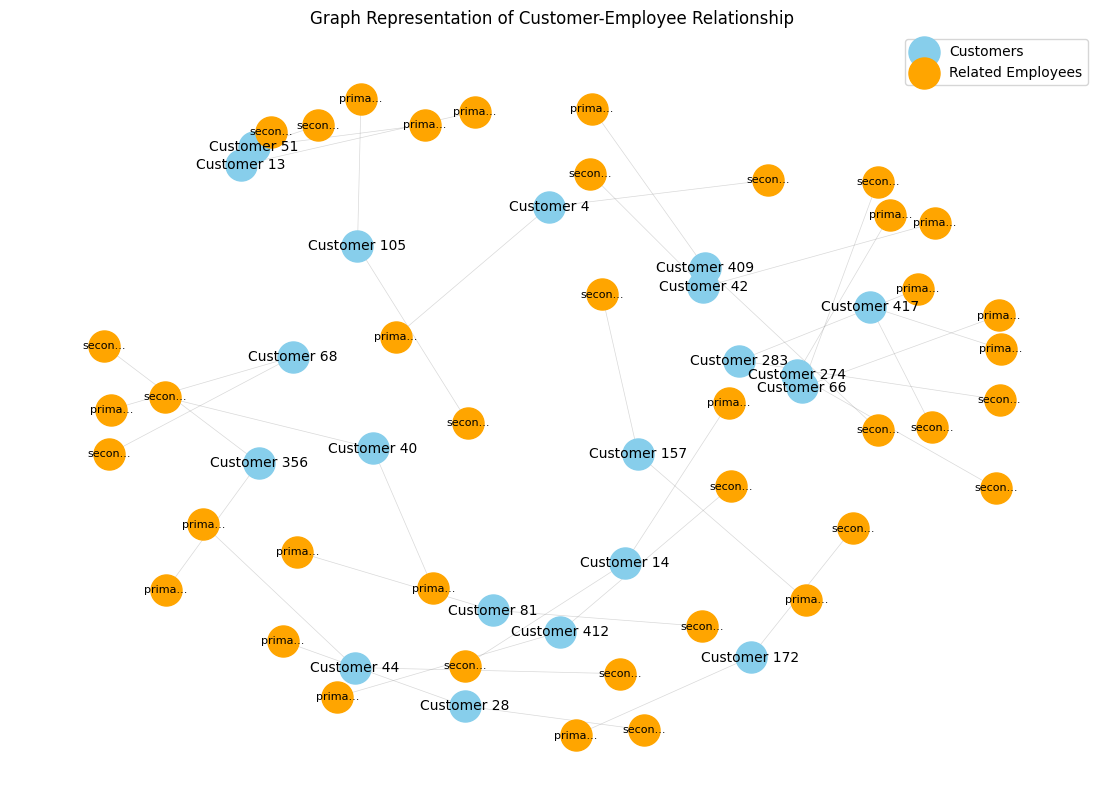

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Abbreviation function for qualifier names
def abbreviate_label(label, max_length=5):
    if len(label) <= max_length:
        return label
    return label[:max_length] + "..."

# Step 1: Subset the data to reduce the number of IDs
num_ids = 40  # Adjust the number of IDs to display
filtered_subset = filtered_dic[:num_ids]  # Take the first N entries

# Step 2: Create the graph
G = nx.Graph()

# Add nodes and edges with unique labels
for idx, (id_, _, qual) in enumerate(filtered_subset):
    unique_qual_node = f"{qual}_{idx}"  # Unique qualifier node
    abbreviated_qual = abbreviate_label(qual)  # Abbreviate qualifier label
    
    G.add_node(id_, type="id", label=f"Customer {id_}")  # ID node
    G.add_node(unique_qual_node, type="qual", label=abbreviated_qual)  # Abbreviated qualifier node
    G.add_edge(id_, unique_qual_node)

# Step 3: Improved Layout
pos = nx.spring_layout(G, k=2, iterations=200, seed=42)

# Separate nodes by type
id_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "id"]
qual_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "qual"]

plt.figure(figsize=(14, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=id_nodes, node_color="skyblue", label="Customers", node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=qual_nodes, node_color="orange", label="Qualifiers", node_size=500)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.3, width=0.5)

# Draw labels
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, {n: labels[n] for n in id_nodes}, font_size=10)  # ID labels
nx.draw_networkx_labels(G, pos, {n: labels[n] for n in qual_nodes}, font_size=8, font_color="black")  # Qualifier labels

# Add legend and title
plt.legend(["Customers", "Related Employees"], loc="upper right")
plt.title(f"Graph Representation of Customer-Employee Relationship")
plt.axis("off")
plt.show()


In [ ]:
print(obs)
connections